In [1]:
from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import glob
import torch
from torch import nn, optim
import numpy as np
import random
import time
import cv2

In [2]:
# img_url = ''
!wget https://images.unsplash.com/photo-1712928247899-2932f4c7dea3 -O living.jpg
!wget https://images.unsplash.com/photo-1712334619829-831fa0625a0f -O dish.jpg
!wget https://images.unsplash.com/photo-1712312610859-eeacc9d9e9f7 -O women.jpg
!wget https://images.unsplash.com/photo-1712797654798-df483a296cc3 -O girl.jpg

--2024-04-28 09:56:27--  https://images.unsplash.com/photo-1712928247899-2932f4c7dea3
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 834037 (814K) [image/jpeg]
Saving to: ‘living.jpg’

living.jpg          100%[===================>] 814.49K  --.-KB/s    in 0.02s   

2024-04-28 09:56:28 (33.5 MB/s) - ‘living.jpg’ saved [834037/834037]

--2024-04-28 09:56:28--  https://images.unsplash.com/photo-1712334619829-831fa0625a0f
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2077230 (2.0M) [image/jpeg]
Saving to: ‘dish.jpg’

dish.jpg            100%[===================>]   1.98M  --.-KB/s    in 0

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()

        self.resblock = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(channels, channels, kernel_size=3),
            nn.InstanceNorm2d(channels, affine=True)
        )

    def forward(self, x):
        out = self.resblock(x)
        return out + x

In [5]:
class Upsample2d(nn.Module):
    def __init__(self, scale_factor):
        super(Upsample2d, self).__init__()
        self.interp = nn.functional.interpolate
        self.scale_factor = scale_factor

    def forward(self, x):
        x = self.interp(x, scale_factor=self.scale_factor, mode='nearest')
        return x

In [6]:
class MicroResNet(nn.Module):
    def __init__(self):
        super(MicroResNet, self).__init__()

        self.downsampler = nn.Sequential(
            nn.ReflectionPad2d(4),
            nn.Conv2d(3,8,kernel_size=9, stride=4),
            nn.InstanceNorm2d(8, affine=True),
            nn.ReLU(),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8,16, kernel_size=3, stride=2),
            nn.InstanceNorm2d(16, affine=True),
            nn.ReLU(),

            nn.ReflectionPad2d(1),
            nn.Conv2d(16,32, kernel_size=3, stride=2),
            nn.InstanceNorm2d(32,affine=True),
            nn.ReLU(),
        )

        self.residual = nn.Sequential(
            ResBlock(32),
            nn.Conv2d(32,64, kernel_size=1, bias=False, groups=32),
            ResBlock(64)
        )

        self.segmentator = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(64,16,kernel_size=3),
            nn.InstanceNorm2d(16,affine=True),
            nn.ReLU(),

            Upsample2d(scale_factor=2),
            nn.ReflectionPad2d(4),
            nn.Conv2d(16,1,kernel_size=9),
            nn.Sigmoid()
        )

    def forward(self,x):
        out = self.downsampler(x)
        out = self.residual(out)
        out = self.segmentator(out)
        return out

In [7]:
model = MicroResNet()
model.load_state_dict(torch.load('/content/drive/MyDrive/datasets/saliency_model_v11.pt'))
model.eval()

MicroResNet(
  (downsampler): Sequential(
    (0): ReflectionPad2d((4, 4, 4, 4))
    (1): Conv2d(3, 8, kernel_size=(9, 9), stride=(4, 4))
    (2): InstanceNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (3): ReLU()
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): ReLU()
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (10): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (11): ReLU()
  )
  (residual): Sequential(
    (0): ResBlock(
      (resblock): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
        (2): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (3): ReLU()
        (4): ReflectionPad2d((1, 1, 1

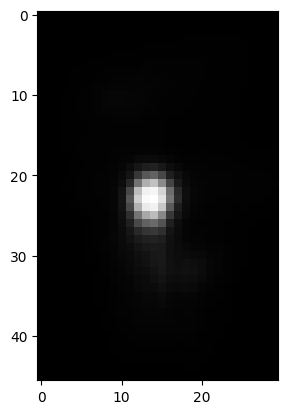

CENTER tensor(14.3014) tensor(23.0687)
(1203, 1893) (803, 1293)


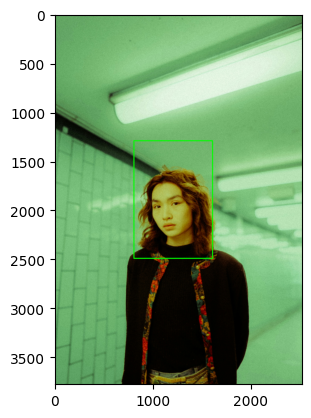

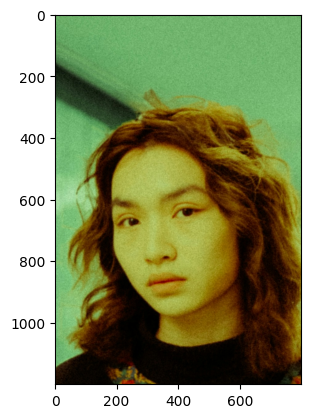

In [8]:
with torch.no_grad():
    path = 'girl.jpg'
    image = Image.open(path)
    image_tensor = transforms.ToTensor()(transforms.Resize(240)(image)).unsqueeze(0)
    image_width, image_height = image.size

    preds = model(image_tensor)[0]
    pred_h, pred_w = preds.size(1), preds.size(2)
    temperature = 0.25
    tempered_pred = torch.log(torch.softmax(preds[0].view(-1), dim=0)) / temperature
    tempered_pred = torch.exp(tempered_pred) / torch.sum(torch.exp(tempered_pred))
    pred = tempered_pred.view(pred_h,pred_w)
    plt.imshow(pred,cmap='Greys_r')
    plt.show()

    center_x, center_y = 0, 0
    for i in range(pred.size(0)):
        for j in range(pred.size(1)):
            center_x += j * pred[i, j]
            center_y += i * pred[i, j]

    print("CENTER", center_x, center_y)

    preds_width, preds_height = preds.permute(2,1,0).shape[:2]
    width_ratio = image_width/preds_width
    height_ratio = image_height/preds_height

#     plt.imshow(np.array(image))
#     plt.show()
    width, height = 800, 1200
    center = (int(width_ratio * center_x),int(height_ratio * center_y))
    top_left = (int(center[0] - width/2),int(center[1]-height/2))
    bottom_right = (int(center[0] + width/2),int(center[1] + height/2))
    marked = cv2.rectangle(np.array(image),top_left,bottom_right,(0,255,0),10)
    print(center,top_left)
    plt.imshow(marked)
    plt.show()

    plt.imshow(np.array(image)[top_left[1]:top_left[1]+height, top_left[0]:top_left[0]+width])
    plt.show()